In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.573878496271703

R-squared complex model:
0.573973445205822

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.864]
 [-0.001 553434.239]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [3]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.5630697922503317

R-squared complex model:
0.563023952731933


Ridge

In [4]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613363

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


Lasso

In [5]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.44363376712897085

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


In [6]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380466345914476


### Regularization parameter: Lasso
The λ for lasso can var between 0 (no penalty, acts like OLS) and infinity. If λ is too large, all parameters will be set to zero.

Create a plot below of how R^2 varies across different values of λ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same R^2 for a given lambda value?

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Rec

   lambda_value  lass_score  ridge_score
0             0    0.573944     0.573973
1            10    0.026834     0.573946
2            20    0.026834     0.573934
3            30    0.026833     0.573920
4            40    0.026832     0.573902


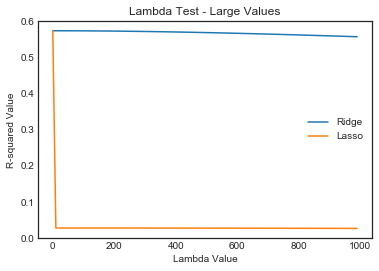

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Rec

   lambda_value  lass_score  ridge_score
0           0.0    0.573944     0.573973
1           0.1    0.563089     0.573972
2           0.2    0.531235     0.573972
3           0.3    0.478145     0.573972
4           0.4    0.403815     0.573971


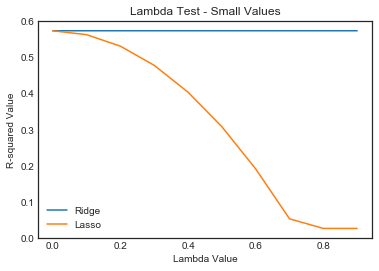

In [25]:
#Test max_features

r_results = pd.DataFrame()

def lambda_test(value):
    #Test lambda value in lasso model
    lass = linear_model.Lasso(alpha=value)
    lassfit = lass.fit(X_train2, Y_train)
    lass_score = lass.score(X_train2, Y_train)
    #Test lambda value in ridge model
    ridgeregr = linear_model.Ridge(alpha=value, fit_intercept=False) 
    ridgeregr.fit(X_train2, Y_train)
    ridge_score = ridgeregr.score(X_train2, Y_train)
    #return dataframe of r-squared for each model
    data = pd.DataFrame({"lambda_value": [value], "lass_score": [lass_score], "ridge_score": [ridge_score]})
    return data

#Test large values for lamdba
appended_data = []
for i in [x * 10 for x in range(0, 100)]:
    result = lambda_test(i)
    appended_data.append(result)
r_results = pd.concat(appended_data, ignore_index=True)

print(r_results.head())

plt.plot(r_results['lambda_value'], r_results['ridge_score'], label="Ridge")
plt.plot(r_results['lambda_value'], r_results['lass_score'], label="Lasso")
plt.xlabel('Lambda Value')
plt.ylabel('R-squared Value')
plt.legend(loc='best') 
plt.title('Lambda Test - Large Values')
plt.show()

#Test small values for lamdba
appended_data = []
for i in [x * 0.1 for x in range(0, 10)]:
    result = lambda_test(i)
    appended_data.append(result)
r_results = pd.concat(appended_data, ignore_index=True)

print(r_results.head())

plt.plot(r_results['lambda_value'], r_results['ridge_score'], label="Ridge")
plt.plot(r_results['lambda_value'], r_results['lass_score'], label="Lasso")
plt.xlabel('Lambda Value')
plt.ylabel('R-squared Value')
plt.legend(loc='best') 
plt.title('Lambda Test - Small Values')
plt.show()